In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
# Load
X = np.load('/home/filsave/malviso/X.npy', allow_pickle=True)
y = np.load('/home/filsave/malviso/y.npy', allow_pickle=True)

In [3]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def get_values(nfeatures, X_train, X_test, y_train, y_test):
    detector = cv2.ORB_create(nfeatures)

    total_kps_train= []
    total_des_train= []
    total_kps_test= []
    total_des_test= []

    for image in X_train:
        query_kps, query_des = detector.detectAndCompute(image, None)
        total_kps_train.append(query_kps)
        total_des_train.append(query_des)

    for image in X_test:
        query_kps, query_des = detector.detectAndCompute(image, None)
        total_kps_test.append(query_kps)
        total_des_test.append(query_des)


    null_indexes_train = []

    for i,e in enumerate(total_des_train):
        if e is None:
            null_indexes_train.append(i)

    total_des_train = np.delete(total_des_train, null_indexes_train).tolist()
    y_train = np.delete(y_train,null_indexes_train).tolist()



    null_indexes_test = []

    for i,e in enumerate(total_des_test):
        if e is None:
            null_indexes_test.append(i)

    total_des_test = np.delete(total_des_test, null_indexes_test).tolist() 
    y_test = np.delete(y_test,null_indexes_test).tolist()



    max0 = 0
    for des in total_des_train:
        if des is not None:
            if des.shape[0] > max0:
                max0 = des.shape[0]

    max1=0
    for des in total_des_test:
        if des is not None:
            if des.shape[0] > max1:
                max1 = des.shape[0]
        
    if max1 > max0:
        max0=max1



    i = 0
    for des in total_des_train:
        padding_to_add = max0 - des.shape[0]
        if padding_to_add != 0:
            pad_list = []
            for k in range(32):
                pad_list.append(0)
            for j in range(padding_to_add):
                total_des_train[i] = np.append(total_des_train[i], pad_list)
            total_des_train[i] = np.array(total_des_train[i]).reshape(max0,32)
        i += 1

    i = 0
    for des in total_des_test:
        padding_to_add = max0 - des.shape[0]
        if padding_to_add != 0:
            pad_list = []
            for k in range(32):
                pad_list.append(0)
            for j in range(padding_to_add):
                total_des_test[i] = np.append(total_des_test[i], pad_list)
            total_des_test[i] = np.array(total_des_test[i]).reshape(max0,32)
        i += 1


    i = 0
    for des in total_des_train:
        total_des_train[i] = np.hstack(des)
        i += 1

    i = 0
    for des in total_des_test:
        total_des_test[i] = np.hstack(des)
        i += 1

    return total_des_train, total_des_test, y_train, y_test

In [8]:
total_des_train, total_des_test , y_train, y_test = get_values(33, X_train, X_test, y_train, y_test) 

Mean F1-score:  0.6441459344241648
Standard deviation:  0.053664320793383666


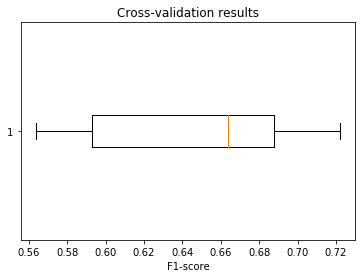

In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
import matplotlib.pyplot as plt

# Define the parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

# Create an instance of the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Create an instance of GridSearchCV
f1_scorer = make_scorer(f1_score, pos_label=1)
grid_search = GridSearchCV(clf, param_grid, cv=10, scoring=f1_scorer)

# Fit the grid search to the data
grid_search.fit(total_des_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Get the best classifier
best_clf = grid_search.best_estimator_

# Use cross_val_score to evaluate the classifier with the best parameters
scores = cross_val_score(best_clf, total_des_test, y_test, cv=10, scoring=f1_scorer)

# Print the mean and standard deviation of the scores
print("Mean F1-score: ", scores.mean())
print("Standard deviation: ", scores.std())

# Plot the results as a box plot
plt.boxplot(scores, vert=False)
plt.xlabel("F1-score")
plt.title("Cross-validation results")
plt.show()

In [10]:
best_params

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

In [11]:
best_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)